In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Load data into pandas dataframe

songs_url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv'

df = pd.read_csv(songs_url)

cleaned_df = df.groupby(['track_id']).first().reset_index()
cleaned_df.shape

cleaned_df_copy = cleaned_df.copy()

cleaned_df_copy['track_popularity_shift'] = np.where( cleaned_df_copy.track_popularity == 100, cleaned_df_copy.track_popularity - 0.1, cleaned_df_copy.track_popularity)
cleaned_df_copy['track_popularity_shift'] = np.where( cleaned_df_copy.track_popularity == 0, cleaned_df_copy.track_popularity + 0.1, cleaned_df_copy.track_popularity_shift )


continuous_columns = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']


# iterate over each continuous variable and apply the shift logic
for col in continuous_columns:
    # shift values for 100
    cleaned_df_copy[f'{col}_shift'] = np.where(cleaned_df_copy[col] == 100, cleaned_df_copy[col] - 0.1, cleaned_df_copy[col])
    # shift values for 0
    cleaned_df_copy[f'{col}_shift'] = np.where(cleaned_df_copy[col] == 0, cleaned_df_copy[col] + 0.1, cleaned_df_copy[f'{col}_shift'])

final_df = cleaned_df_copy.copy()

final_df['track_popularity_frac'] = final_df.track_popularity_shift / 100
final_df['y'] = np.log( final_df.track_popularity_frac / (1 - final_df.track_popularity_frac) )
final_df.drop(columns='track_popularity_shift', inplace=True)
final_df.drop(columns='track_popularity_frac', inplace=True)

for col in continuous_columns:
    # divide by 100
    final_df[f'{col}_frac'] = final_df[f'{col}_shift'] / 100
    
    final_df[f'{col}_frac'] = np.clip(final_df[f'{col}_shift'], 1e-10, 1 - 1e-10)
    final_df.drop(columns=f'{col}_shift', inplace=True)
 
    # calculate logit transformation
    final_df[f'{col}_log'] = np.log(final_df[f'{col}_frac'] / (1 - final_df[f'{col}_frac']))
    
    
    final_df.drop(columns=f'{col}_frac', inplace=True)
    

final_df.describe()

track_popularity  danceability        energy           key  \
count      28356.000000  28356.000000  28356.000000  28356.000000   
mean          39.329771      0.653372      0.698388      5.368000   
std           23.702376      0.145785      0.183503      3.613904   
min            0.000000      0.000000      0.000175      0.000000   
25%           21.000000      0.561000      0.579000      2.000000   
50%           42.000000      0.670000      0.722000      6.000000   
75%           58.000000      0.760000      0.843000      9.000000   
max          100.000000      0.983000      1.000000     11.000000   

           loudness          mode   speechiness  acousticness  \
count  28356.000000  28356.000000  28356.000000  28356.000000   
mean      -6.817696      0.565489      0.107954      0.177176   
std        3.036243      0.495701      0.102556      0.222803   
min      -46.448000      0.000000      0.000000      0.000000   
25%       -8.309250      0.000000      0.041000      0.014375   
50%       -6.261000      1.000000      0.062600      0.079700   
75%       -4.709000      1.000000      0.133000      0.260000   
max        1.275000      1.000000      0.918000      0.994000   

       instrumentalness      liveness  ...    duration_ms             y  \
count      28356.000000  28356.000000  ...   28356.000000  28356.000000   
mean           0.091117      0.190958  ...  226575.967026     -1.032966   
std            0.232548      0.155894  ...   61078.450819      2.224323   
min            0.000000      0.000000  ...    4000.000000     -6.906755   
25%            0.000000      0.092600  ...  187742.000000     -1.324925   
50%            0.000021      0.127000  ...  216933.000000     -0.322773   
75%            0.006570      0.249000  ...  254975.250000      0.322773   
max            0.994000      0.996000  ...  517810.000000      6.906755   

       danceability_log    energy_log  loudness_log  speechiness_log  \
count      28356.000000  28356.000000  28356.000000     28356.000000   
mean           0.704743      1.044172    -23.019382        -2.439812   
std            0.715020      1.119592      0.472372         0.898125   
min           -2.482418     -8.650550    -23.025851        -3.776040   
25%            0.245221      0.318670    -23.025851        -3.152319   
50%            0.708185      0.954404    -23.025851        -2.706345   
75%            1.152680      1.680721    -23.025851        -1.874690   
max            4.057396     23.025851     23.025851         2.415478   

       acousticness_log  instrumentalness_log  liveness_log   valence_log  
count      28356.000000          28356.000000  28356.000000  28356.000000  
mean          -2.780104             -4.808263     -1.662601      0.059206  
std            2.515573              4.282268      0.955995      1.223527  
min          -13.479037            -13.815510     -4.661906    -11.512915  
25%           -4.226022             -8.381560     -2.282294     -0.712711  
50%           -2.446430             -2.197225     -1.927748      0.048009  
75%           -1.045969             -2.197225     -1.103953      0.823600  
max            5.109978              5.109978      5.517453      4.701490  

[8 rows x 22 columns]

In [80]:
cleaned_df.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')

In [81]:
final_df.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'y', 'danceability_log', 'energy_log', 'loudness_log',
       'speechiness_log', 'acousticness_log', 'instrumentalness_log',
       'liveness_log', 'valence_log'],
      dtype='object')

#### Preprocess

#### Standardize Log Transformed DF 

In [82]:
log_transformed_df = final_df[['y', 'danceability_log', 'energy_log', 'loudness_log',
       'speechiness_log', 'acousticness_log', 'instrumentalness_log',
       'liveness_log', 'valence_log']]

In [83]:
log_transformed_df

y  danceability_log  energy_log  loudness_log  speechiness_log  \
0     -0.363965          0.762978   -0.401300    -23.025851        -3.722626   
1     -1.734601          0.330989    0.866419    -23.025851        -3.325699   
2     -0.944462         -0.833053    1.992430    -23.025851        -3.073824   
3     -1.152680          0.658841    1.349207    -23.025851        -2.863259   
4     -0.489548          0.672220    1.643422    -23.025851        -2.946546   
...         ...               ...         ...           ...              ...   
28351  0.944462          1.066864    0.919793    -23.025851        -0.614646   
28352 -0.575364          1.599868    0.690149    -23.025851        -2.694478   
28353 -0.040005          3.259135    0.417981    -23.025851        -1.516347   
28354 -0.405465         -0.168397    0.160343    -23.025851        -3.584547   
28355  0.447312          0.681171    0.148271    -23.025851        -3.511031   

       acousticness_log  instrumentalness_log  liveness_log  valence_log  
0             -0.949427             -4.436397     -2.329612     0.265550  
1             -2.664515             -2.197225     -1.312912     0.837792  
2             -4.436397             -4.601199     -0.632252    -0.388826  
3             -7.180116             -1.883390     -0.744596     1.750374  
4             -2.050519             -7.268028     -2.337058    -0.016000  
...                 ...                   ...           ...          ...  
28351         -2.186163             -2.197225     -2.290653    -0.663294  
28352         -1.790593             -2.197225     -2.556366     1.450010  
28353         -2.628923            -12.035480     -1.300981     0.605878  
28354          0.919793             -7.755959     -2.040656     0.649954  
28355         -1.283235            -12.757717     -2.011507    -1.259848  

[28356 rows x 9 columns]

In [47]:
log_transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28356 entries, 0 to 28355
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   y                     28356 non-null  float64
 1   danceability_log      28356 non-null  float64
 2   energy_log            28356 non-null  float64
 3   loudness_log          28356 non-null  float64
 4   speechiness_log       28356 non-null  float64
 5   acousticness_log      28356 non-null  float64
 6   instrumentalness_log  28356 non-null  float64
 7   liveness_log          28356 non-null  float64
 8   valence_log           28356 non-null  float64
dtypes: float64(9)
memory usage: 1.9 MB


In [48]:
X = StandardScaler().fit_transform(log_transformed_df)

In [49]:
X = StandardScaler().fit_transform(log_transformed_df)

In [50]:
X.shape

(28356, 9)

In [51]:
type( X )

numpy.ndarray

In [52]:
pca_music_features = PCA(n_components=2).fit_transform( X )

In [53]:
pca_music_features.shape

(28356, 2)

In [15]:
pca_music_features_df = pd.DataFrame( pca_music_features, columns=['pc01', 'pc02'] )

In [103]:
pca_music_features_df

pc01      pc02
0      1.920013 -0.071774
1     -0.589052  0.352519
2     -1.560738  2.139539
3     -1.313551 -0.500656
4     -0.597554  0.253221
...         ...       ...
28351 -0.057159 -1.092398
28352 -0.374680 -1.572221
28353 -0.079496 -1.834985
28354  1.624073  0.162525
28355  0.774449  0.641389

[28356 rows x 2 columns]

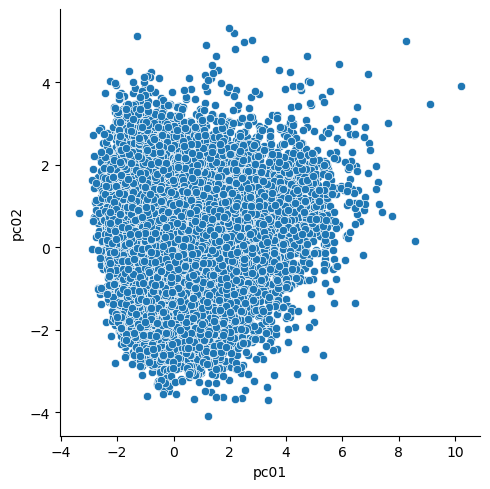

In [55]:
sns.relplot(data = pca_music_features_df, x='pc01', y='pc02')
plt.show()

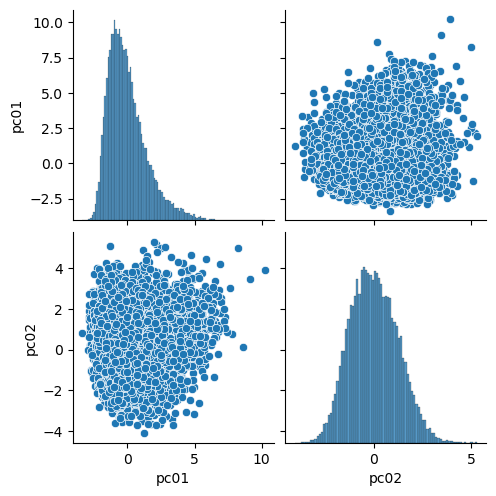

In [56]:
sns.pairplot(data = pca_music_features_df)
plt.show()

#### Standardize Original DF 

In [19]:
original_df = cleaned_df[['track_popularity','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence']]

In [20]:
original_df

track_popularity  danceability  energy  key  loudness  mode  \
0                    41         0.682   0.401    2   -10.068     1   
1                    15         0.582   0.704    5    -6.242     1   
2                    28         0.303   0.880    9    -4.739     1   
3                    24         0.659   0.794   10    -5.644     0   
4                    38         0.662   0.838    1    -6.300     1   
...                 ...           ...     ...  ...       ...   ...   
28351                72         0.744   0.715    0    -6.103     1   
28352                36         0.832   0.666    1    -4.920     0   
28353                49         0.963   0.603    2    -6.224     1   
28354                40         0.458   0.540    5    -6.457     0   
28355                61         0.664   0.537    2    -6.000     1   

       speechiness  acousticness  instrumentalness  liveness  valence  
0           0.0236      0.279000          0.011700    0.0887    0.566  
1           0.0347      0.065100          0.000000    0.2120    0.698  
2           0.0442      0.011700          0.009940    0.3470    0.404  
3           0.0540      0.000761          0.132000    0.3220    0.852  
4           0.0499      0.114000          0.000697    0.0881    0.496  
...            ...           ...               ...       ...      ...  
28351       0.3510      0.101000          0.000000    0.0919    0.340  
28352       0.0633      0.143000          0.000000    0.0720    0.810  
28353       0.1800      0.067300          0.000006    0.2140    0.647  
28354       0.0270      0.715000          0.000428    0.1150    0.657  
28355       0.0290      0.217000          0.000003    0.1180    0.221  

[28356 rows x 11 columns]

In [21]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28356 entries, 0 to 28355
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_popularity  28356 non-null  int64  
 1   danceability      28356 non-null  float64
 2   energy            28356 non-null  float64
 3   key               28356 non-null  int64  
 4   loudness          28356 non-null  float64
 5   mode              28356 non-null  int64  
 6   speechiness       28356 non-null  float64
 7   acousticness      28356 non-null  float64
 8   instrumentalness  28356 non-null  float64
 9   liveness          28356 non-null  float64
 10  valence           28356 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 2.4 MB


In [22]:
X = StandardScaler().fit_transform(original_df)

In [23]:
X = StandardScaler().fit_transform(original_df)

In [24]:
X.shape

(28356, 11)

In [25]:
type( X )

numpy.ndarray

In [26]:
pca_music_features = PCA(n_components=2).fit_transform( X )

In [27]:
pca_music_features.shape

(28356, 2)

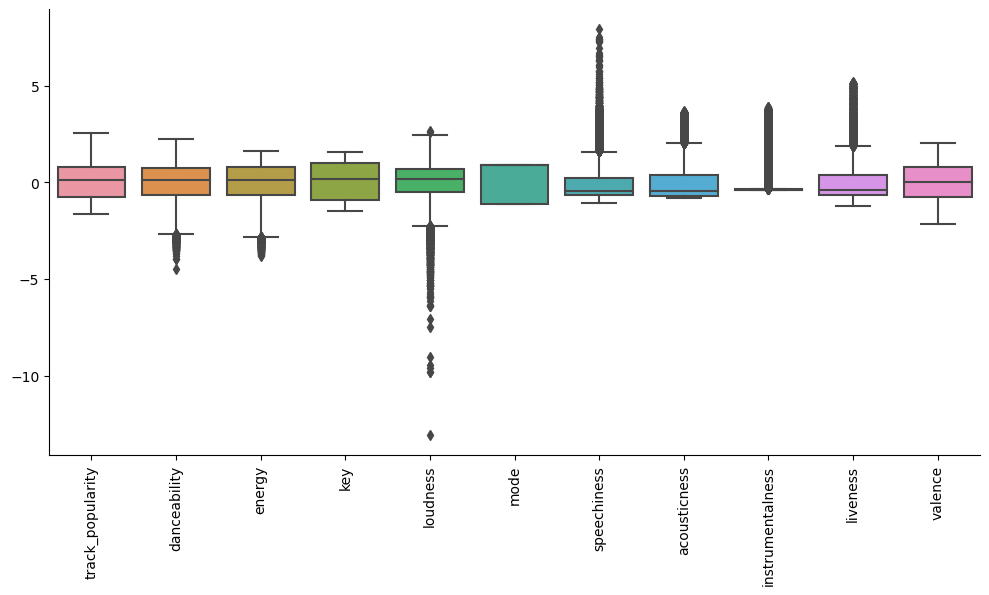

In [28]:
sns.catplot(data=pd.DataFrame(X, columns=original_df.columns), kind='box', aspect=2)
plt.xticks(rotation=90)
plt.show()

In [29]:
pca_music_features_df = pd.DataFrame( pca_music_features, columns=['pc01', 'pc02'] )

In [30]:
pca_music_features_df

pc01      pc02
0      1.920013 -0.071774
1     -0.589052  0.352519
2     -1.560738  2.139539
3     -1.313551 -0.500656
4     -0.597554  0.253221
...         ...       ...
28351 -0.057159 -1.092398
28352 -0.374680 -1.572221
28353 -0.079496 -1.834985
28354  1.624073  0.162525
28355  0.774449  0.641389

[28356 rows x 2 columns]

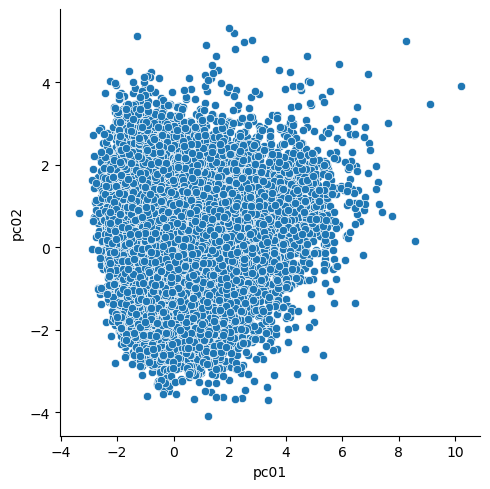

In [31]:
sns.relplot(data = pca_music_features_df, x='pc01', y='pc02')
plt.show()

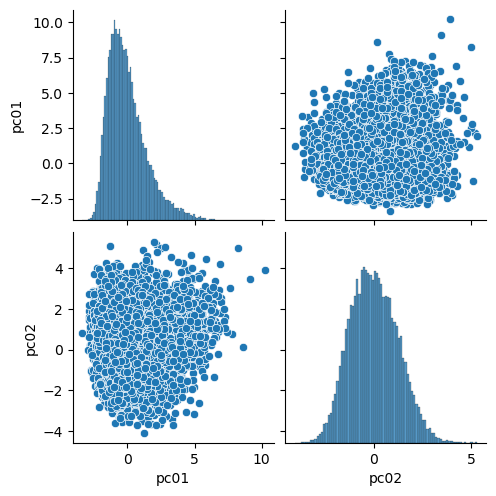

In [32]:
sns.pairplot(data = pca_music_features_df)
plt.show()

#### Hierarchical Clustering

In [33]:
from scipy.cluster import hierarchy

In [34]:
hclust_complete = hierarchy.complete( X )

In [35]:
type( hclust_complete )

numpy.ndarray

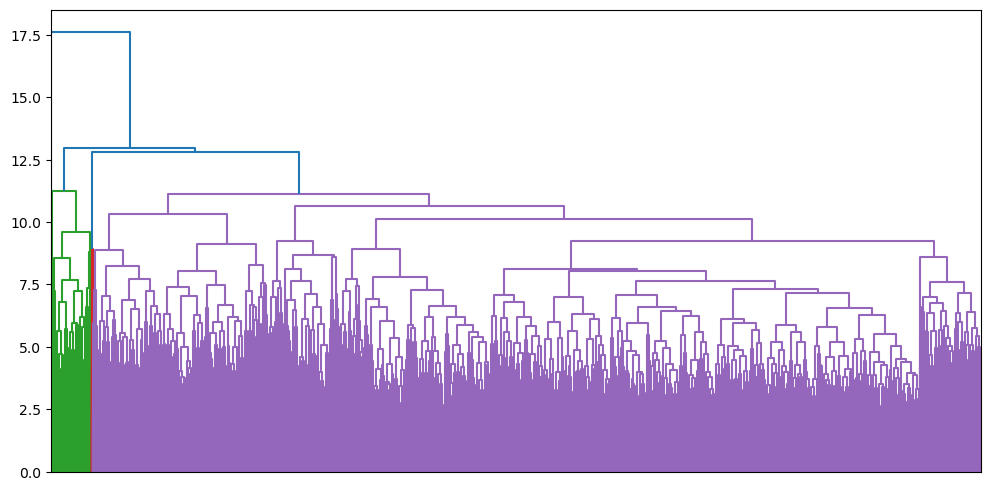

In [37]:
fig = plt.figure(figsize=(12, 6))

dn = hierarchy.dendrogram( hclust_complete, no_labels=True )

plt.show()

In [ ]:
hclust_single = hierarchy.single( X )
fig = plt.figure(figsize=(12, 6))

dn = hierarchy.dendrogram( hclust_single, no_labels=True )

plt.show()

#### KMeans

In [64]:
X.shape

(28356, 9)

In [66]:
clusters_2 = KMeans( n_clusters=2, random_state=121, n_init=25, max_iter=500 ).fit_predict( X )

In [67]:
log_transformed_df_copy = log_transformed_df.copy()
log_transformed_df_copy['k2'] = pd.Series( clusters_2, index=log_transformed_df_copy.index ).astype('category')
log_transformed_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28356 entries, 0 to 28355
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   y                     28356 non-null  float64 
 1   danceability_log      28356 non-null  float64 
 2   energy_log            28356 non-null  float64 
 3   loudness_log          28356 non-null  float64 
 4   speechiness_log       28356 non-null  float64 
 5   acousticness_log      28356 non-null  float64 
 6   instrumentalness_log  28356 non-null  float64 
 7   liveness_log          28356 non-null  float64 
 8   valence_log           28356 non-null  float64 
 9   k2                    28356 non-null  category
dtypes: category(1), float64(9)
memory usage: 2.0 MB


In [68]:
log_transformed_df_copy.nunique()

y                        101
danceability_log         822
energy_log               952
loudness_log               6
speechiness_log         1269
acousticness_log        3730
instrumentalness_log    4728
liveness_log            1623
valence_log             1361
k2                         2
dtype: int64

In [69]:
log_transformed_df_copy.k2.value_counts()

0    18014
1    10342
Name: k2, dtype: int64

In [70]:
log_transformed_df_copy.columns

Index(['y', 'danceability_log', 'energy_log', 'loudness_log',
       'speechiness_log', 'acousticness_log', 'instrumentalness_log',
       'liveness_log', 'valence_log', 'k2'],
      dtype='object')

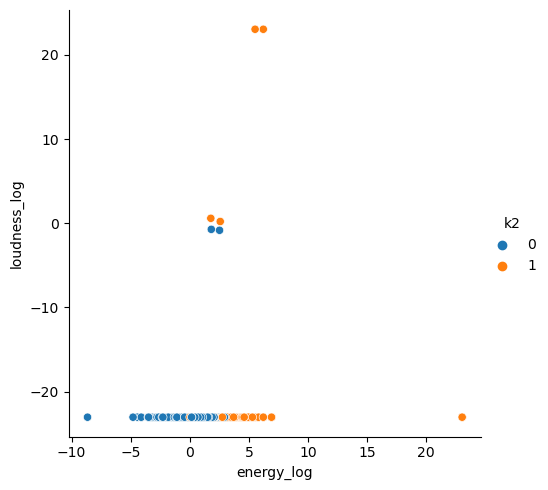

In [72]:
sns.relplot(data = log_transformed_df_copy, x='energy_log', y='loudness_log', hue='k2')
plt.show()

In [ ]:
sns.relplot(data = log_transformed_df_copy, x='energy_log', y='loudness_log', hue='k2')

plt.show()

In [73]:
tots_within = []

K = range(1, 31)

for k in K:
    km = KMeans(n_clusters=k, random_state=121, n_init=25, max_iter=500)
    km = km.fit( X )
    
    tots_within.append( km.inertia_ )

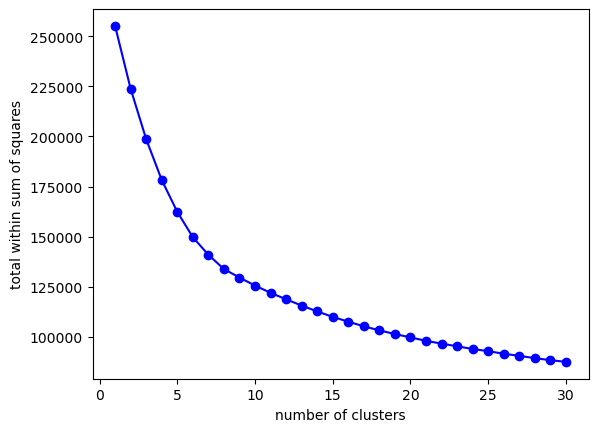

In [74]:
fig, ax = plt.subplots()

ax.plot( K, tots_within, 'bo-' )
ax.set_xlabel('number of clusters')
ax.set_ylabel('total within sum of squares')

plt.show()

#### Hierarchical Clustering

In [88]:
columns_for_clustering = ['y', 'danceability_log', 'energy_log', 'loudness_log', 'speechiness_log', 'acousticness_log', 'instrumentalness_log', 'liveness_log', 'valence_log']

In [89]:
# standardize the data
X_spotify = StandardScaler().fit_transform(final_df[columns_for_clustering])

In [90]:
# perform hierarchical clustering using Ward method
hclust_ward_spotify = hierarchy.ward(X_spotify)

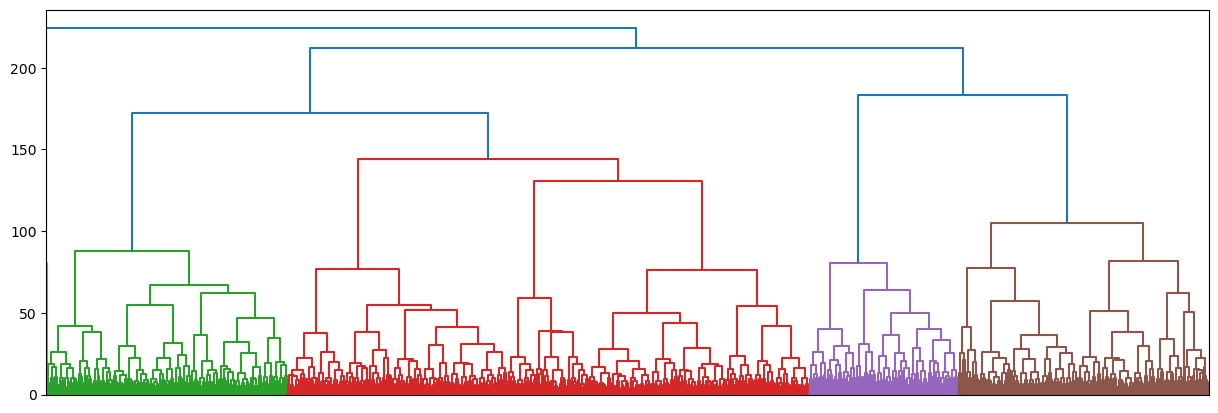

In [102]:
# visualize the dendrogram
fig = plt.figure(figsize=(15, 5))
dn = hierarchy.dendrogram(hclust_ward_spotify, no_labels=True)
plt.show()

In [104]:
#### use the cluster results

In [131]:
# cut the tree based on a height or specify the number of clusters
# adjust the height or number of clusters based on the dataset
cluster_labels_spotify = hierarchy.cut_tree(hclust_ward_spotify, n_clusters=3).ravel()

In [132]:
pca_music_features_df

pc01      pc02 hclust_3 playlist_genre
0      1.920013 -0.071774        0           rock
1     -0.589052  0.352519        0            r&b
2     -1.560738  2.139539        0           rock
3     -1.313551 -0.500656        0            pop
4     -0.597554  0.253221        0            pop
...         ...       ...      ...            ...
28351 -0.057159 -1.092398        0            r&b
28352 -0.374680 -1.572221        0            r&b
28353 -0.079496 -1.834985        0            pop
28354  1.624073  0.162525        0            r&b
28355  0.774449  0.641389        0           rock

[28356 rows x 4 columns]

In [133]:
# add cluster labels to the original dataset
pca_music_features_df['hclust_3'] = pd.Series(cluster_labels_spotify, index=final_df.index).astype('category')

In [134]:
pca_music_features_df

pc01      pc02 hclust_3 playlist_genre
0      1.920013 -0.071774        0           rock
1     -0.589052  0.352519        1            r&b
2     -1.560738  2.139539        1           rock
3     -1.313551 -0.500656        1            pop
4     -0.597554  0.253221        0            pop
...         ...       ...      ...            ...
28351 -0.057159 -1.092398        0            r&b
28352 -0.374680 -1.572221        0            r&b
28353 -0.079496 -1.834985        0            pop
28354  1.624073  0.162525        0            r&b
28355  0.774449  0.641389        0           rock

[28356 rows x 4 columns]

In [135]:
# display the count of observations in each cluster
print(pca_music_features_df['hclust_3'].value_counts())

0    18611
1     9739
2        6
Name: hclust_3, dtype: int64


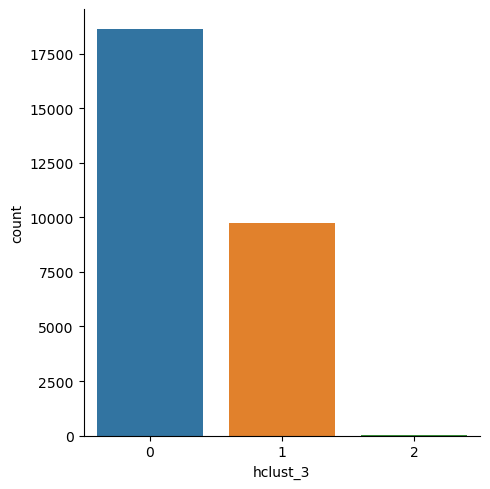

In [136]:
sns.catplot(data = pca_music_features_df, x='hclust_3', kind='count')
plt.show()

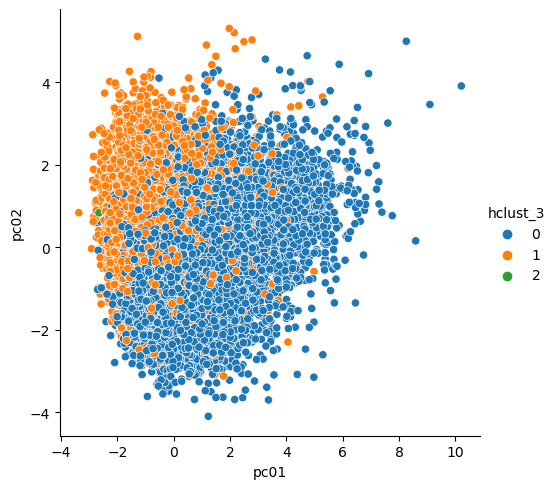

In [137]:
sns.relplot(data = pca_music_features_df, x='pc01', y='pc02', hue='hclust_3')
plt.show()

In [138]:
final_df['playlist_genre'] = final_df.playlist_genre.astype('category')

In [139]:
pca_music_features_df['playlist_genre'] = final_df.playlist_genre
pca_music_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28356 entries, 0 to 28355
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   pc01            28356 non-null  float64 
 1   pc02            28356 non-null  float64 
 2   hclust_3        28356 non-null  category
 3   playlist_genre  28356 non-null  category
dtypes: category(2), float64(2)
memory usage: 498.9 KB


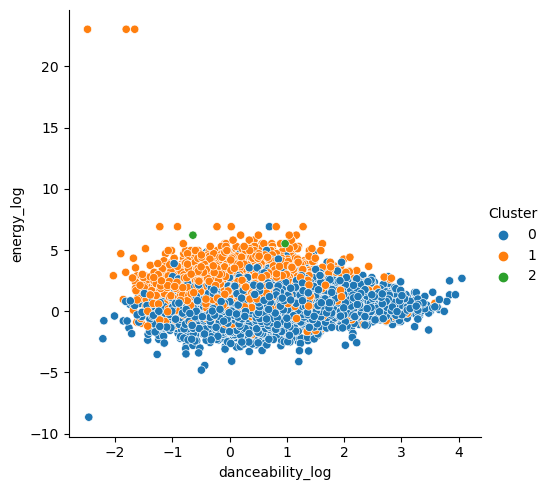

In [140]:
# # Visualize the clusters in a scatter plot (assuming you have 2 features for simplicity)
# sns.relplot(data=final_df, x='danceability_log', y='energy_log', hue='Cluster')
# plt.show()

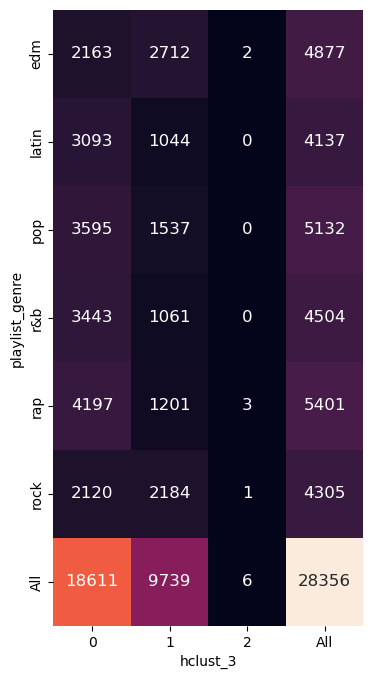

In [165]:
# Compare clusters to the known categories (playlist_genre)
fig, ax = plt.subplots(figsize=(4, 8))
sns.heatmap(data=pd.crosstab(pca_music_features_df['playlist_genre'], pca_music_features_df['hclust_3'], margins=True),
            annot=True, annot_kws={'fontsize': 12}, fmt='g', cbar=False, ax=ax)
plt.show()


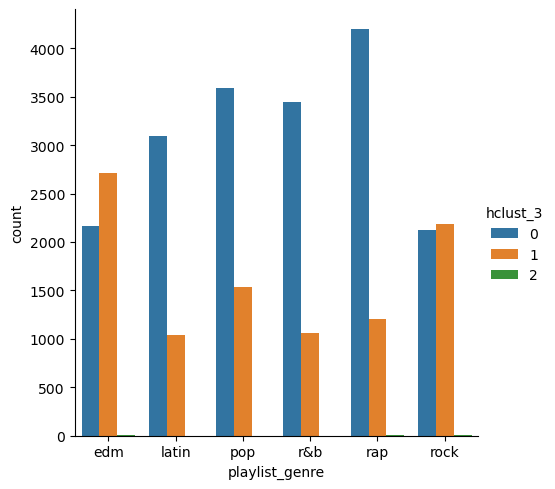

In [166]:
sns.catplot(data = pca_music_features_df, x='playlist_genre', hue='hclust_3', kind='count')
plt.show()

In [168]:
final_copy = log_transformed_df.copy()
final_copy['hclust_3'] = pca_music_features_df.hclust_3
final_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28356 entries, 0 to 28355
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   track_id                  28356 non-null  object  
 1   track_name                28352 non-null  object  
 2   track_artist              28352 non-null  object  
 3   track_popularity          28356 non-null  int64   
 4   track_album_id            28356 non-null  object  
 5   track_album_name          28352 non-null  object  
 6   track_album_release_date  28356 non-null  object  
 7   playlist_name             28356 non-null  object  
 8   playlist_id               28356 non-null  object  
 9   playlist_genre            28356 non-null  object  
 10  playlist_subgenre         28356 non-null  object  
 11  danceability              28356 non-null  float64 
 12  energy                    28356 non-null  float64 
 13  key                       28356 non-null  int6

In [170]:
lf = final_copy.reset_index().\
rename(columns={'index': 'rowid'}).\
melt(id_vars=['rowid', 'playlist_genre', 'hclust_3'],
     value_vars=['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'])

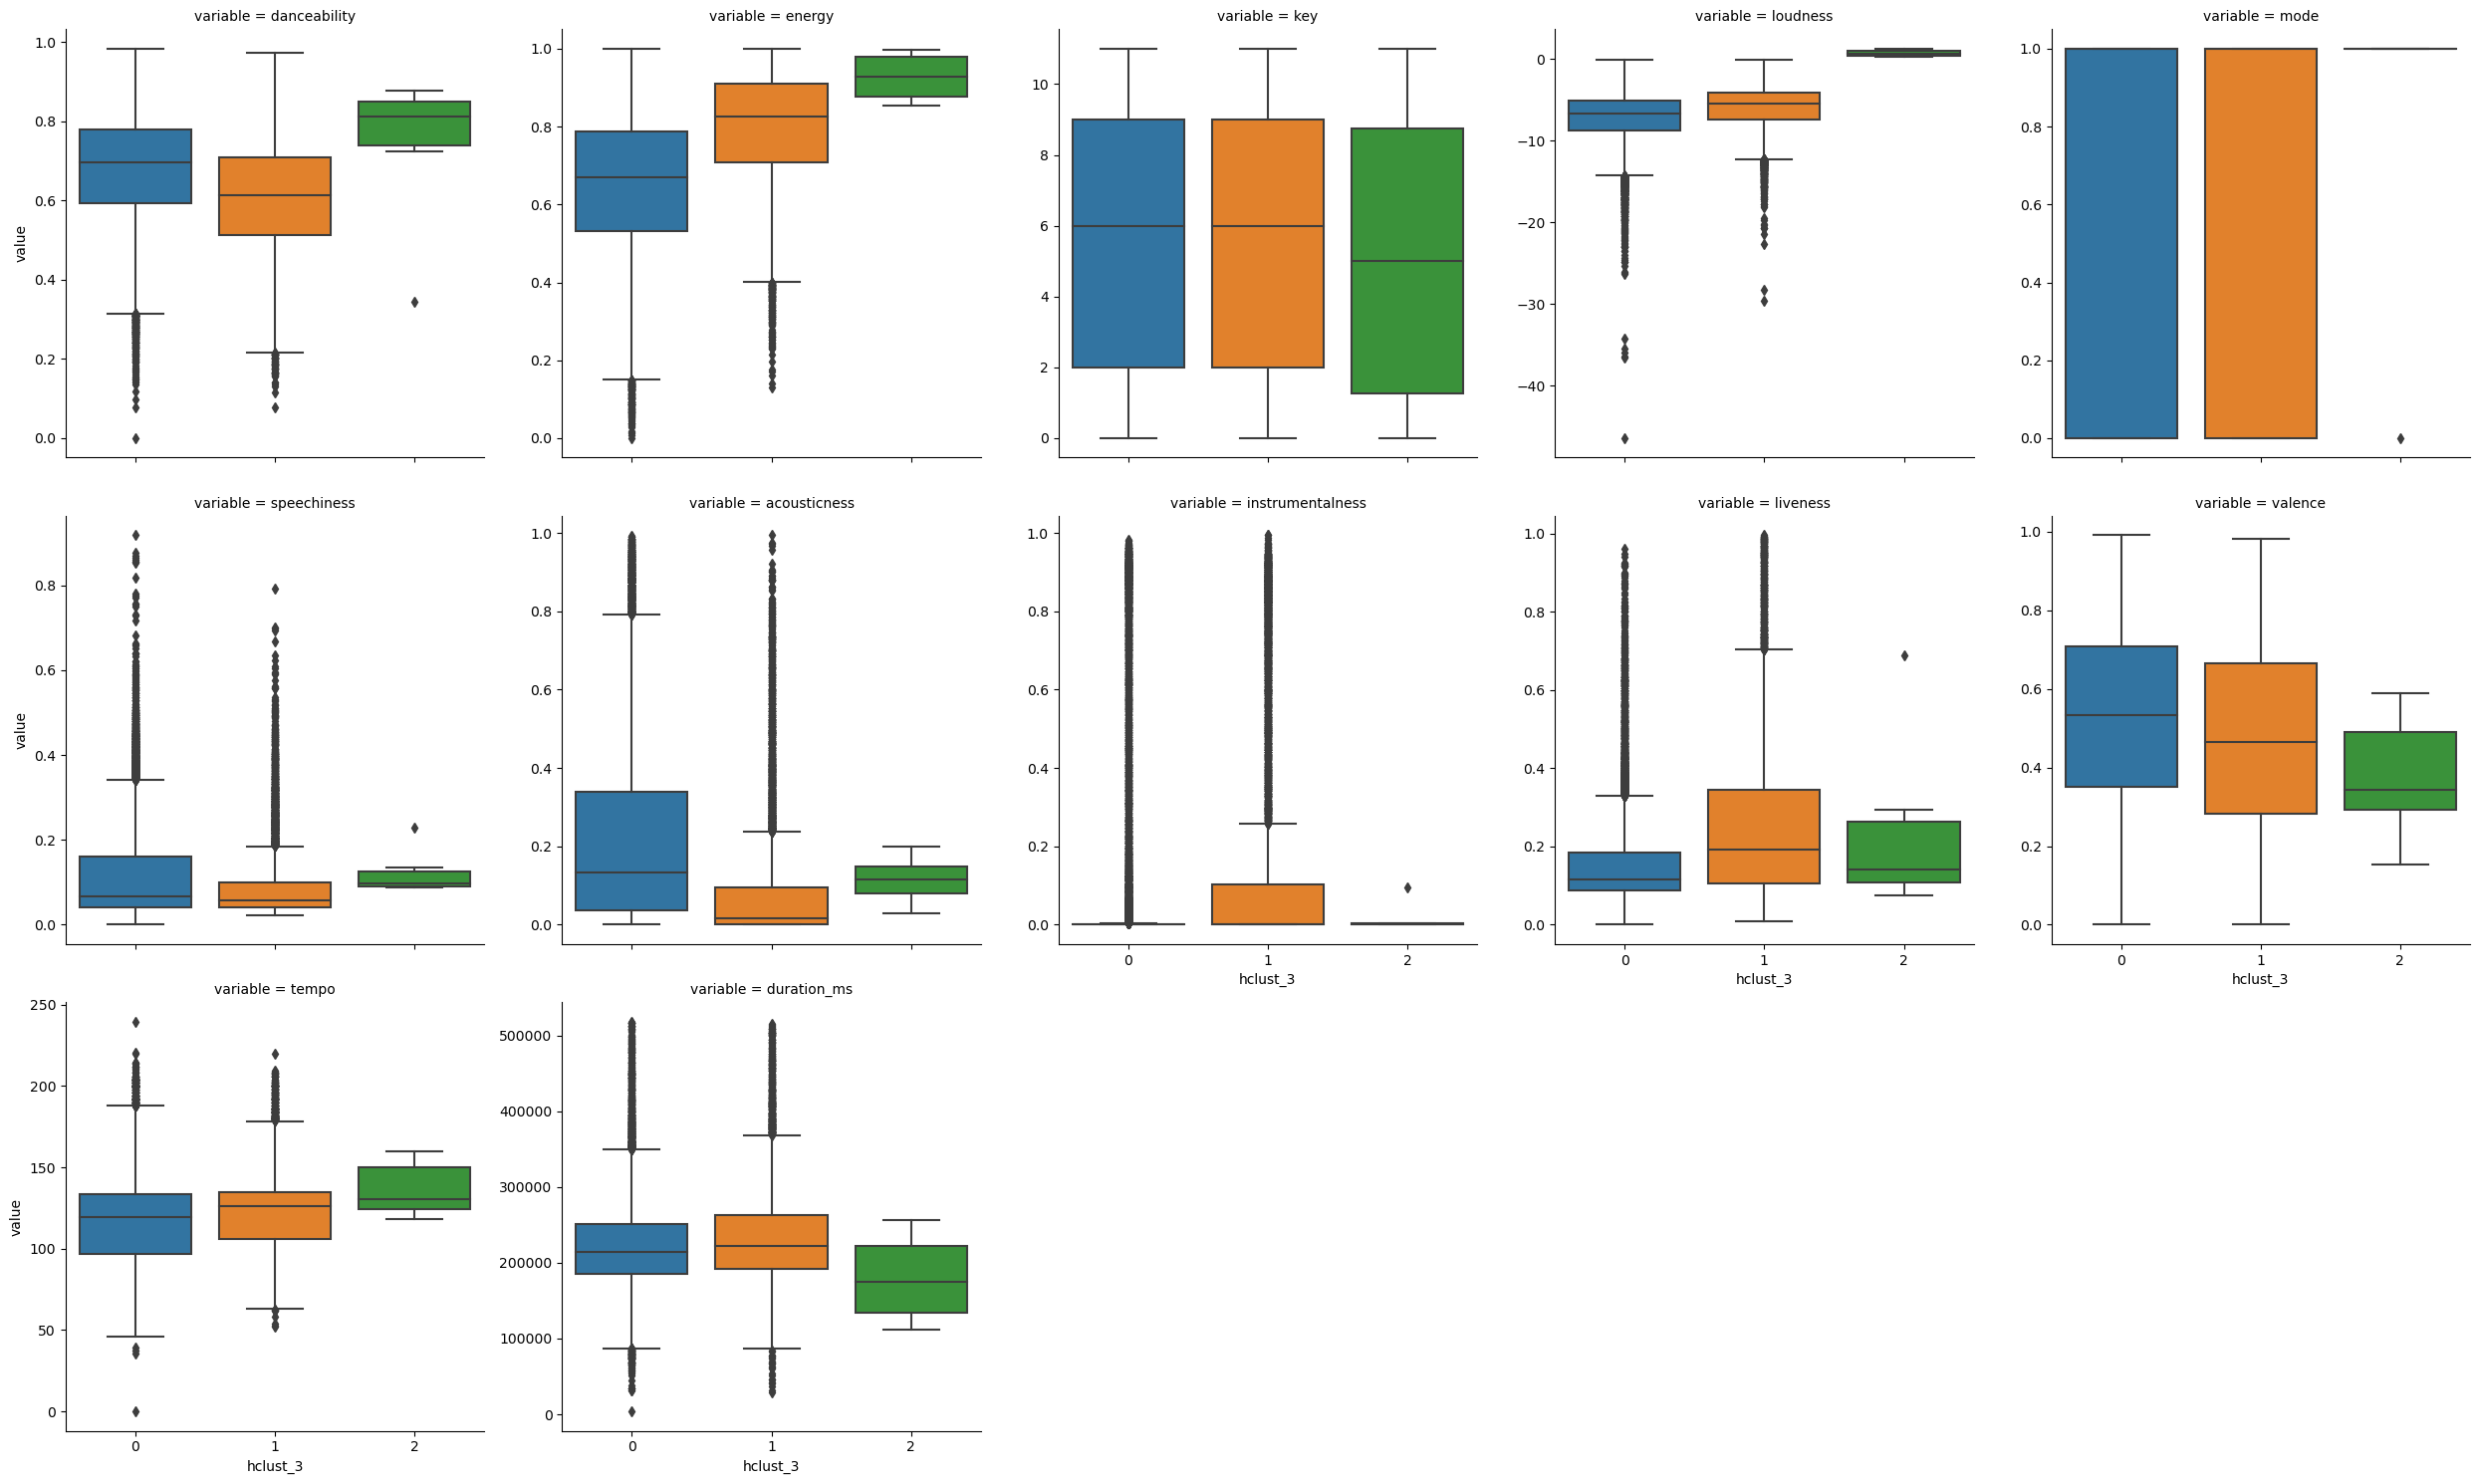

In [171]:
sns.catplot(data = lf, x='hclust_3', y='value', col='variable', col_wrap=5,
            kind='box',
            sharey=False)

plt.show()